In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix

In [37]:
exclude_labels = [0] # colocar aqui as labels que quiser descartar
train = pd.read_parquet('./data/TRAIN_person3_car2_dog3_cow2_noise3.parquet').sample(frac=1)
train = train[~train['label'].isin(exclude_labels)]
train_matrices = train.iloc[:, 1:].values.reshape(-1, 500, 52).transpose(0, 2, 1).astype(np.float16)
#train_matrices /= abs(np.expand_dims(train_matrices.mean(axis=2).mean(axis=1), axis=[1, 2]))

test = pd.read_parquet('./data/TEST_person3_car2_dog3_cow2_noise3.parquet').sample(frac=1)
test = test[~test['label'].isin(exclude_labels)]
test_matrices = test.iloc[:, 1:].values.reshape(-1, 500, 52).transpose(0, 2, 1).astype(np.float16)
#test_matrices /= abs(np.expand_dims(test_matrices.mean(axis=2).mean(axis=1), axis=[1, 2]))

train_carrier_means = train_matrices.mean(axis=2)
train_carrier_stds = train_matrices.std(axis=2)

test_carrier_means = test_matrices.mean(axis=2)
test_carrier_stds = test_matrices.std(axis=2)

train_features = np.concatenate([train_carrier_means, train_carrier_stds], axis=1)
test_features = np.concatenate([test_carrier_means, test_carrier_stds], axis=1)

array([1., 3., 2., 4.])

In [68]:
print(train_features.shape)
print(test_features.shape)

(616, 104)
(161, 104)


In [69]:
label_map = {
    0: 'background',
    1: 'person',
    2: 'car',
    3: 'dog',
    4: 'cow'
}


train_means_df = pd.DataFrame(train_carrier_means, columns=[f'c{i}' for i in range(52)])
train_means_df['label'] = train['label'].reset_index(drop=True).apply(lambda x: label_map[x])
train_means_df

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c43,c44,c45,c46,c47,c48,c49,c50,c51,label
0,-84.0000,-84.1250,-84.1250,-84.1875,-84.1250,-84.1250,-84.0625,-83.8750,-83.6875,-83.5000,...,-83.4375,-83.4375,-83.5000,-83.6250,-83.8125,-83.9375,-84.0000,-84.0625,-84.1250,car
1,-78.3750,-78.4375,-78.4375,-78.5000,-78.5000,-78.5625,-78.6250,-78.6250,-78.7500,-78.8750,...,-82.0000,-81.9375,-81.8750,-81.8750,-81.8750,-81.8750,-81.8125,-81.7500,-81.6875,person
2,-81.7500,-81.9375,-82.0625,-82.1875,-82.2500,-82.3125,-82.3750,-82.4375,-82.5625,-82.6250,...,-80.6250,-80.5625,-80.5000,-80.5000,-80.5000,-80.5625,-80.5000,-80.4375,-80.3750,person
3,-83.6875,-83.8125,-83.8750,-83.8750,-83.8750,-83.8125,-83.7500,-83.6250,-83.5000,-83.3125,...,-83.3750,-83.3750,-83.3750,-83.5000,-83.6875,-83.8125,-83.8750,-83.9375,-84.0000,car
4,-83.3125,-83.3125,-83.3750,-83.3750,-83.3125,-83.3125,-83.1875,-83.0000,-82.8750,-82.7500,...,-80.5625,-80.5625,-80.5000,-80.5000,-80.5625,-80.5625,-80.5625,-80.5625,-80.4375,car
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,-78.5000,-78.6250,-78.6250,-78.6875,-78.6875,-78.7500,-78.8125,-78.8750,-78.9375,-79.0625,...,-82.0000,-81.8750,-81.8750,-81.8125,-81.8125,-81.8125,-81.7500,-81.6875,-81.6250,person
612,-81.9375,-82.1250,-82.2500,-82.3750,-82.4375,-82.5000,-82.6250,-82.6250,-82.6875,-82.7500,...,-80.6875,-80.6250,-80.5625,-80.5625,-80.5625,-80.6250,-80.5625,-80.5000,-80.4375,person
613,-78.3750,-78.4375,-78.5000,-78.5000,-78.5625,-78.6250,-78.6250,-78.6875,-78.7500,-78.8750,...,-82.0000,-81.9375,-81.9375,-81.8750,-81.8750,-81.8750,-81.8125,-81.8125,-81.7500,person
614,-83.5625,-83.6875,-83.7500,-83.7500,-83.6875,-83.6250,-83.5625,-83.3750,-83.1250,-82.9375,...,-82.4375,-82.4375,-82.4375,-82.6250,-82.8125,-82.9375,-83.0000,-83.1250,-83.1875,car


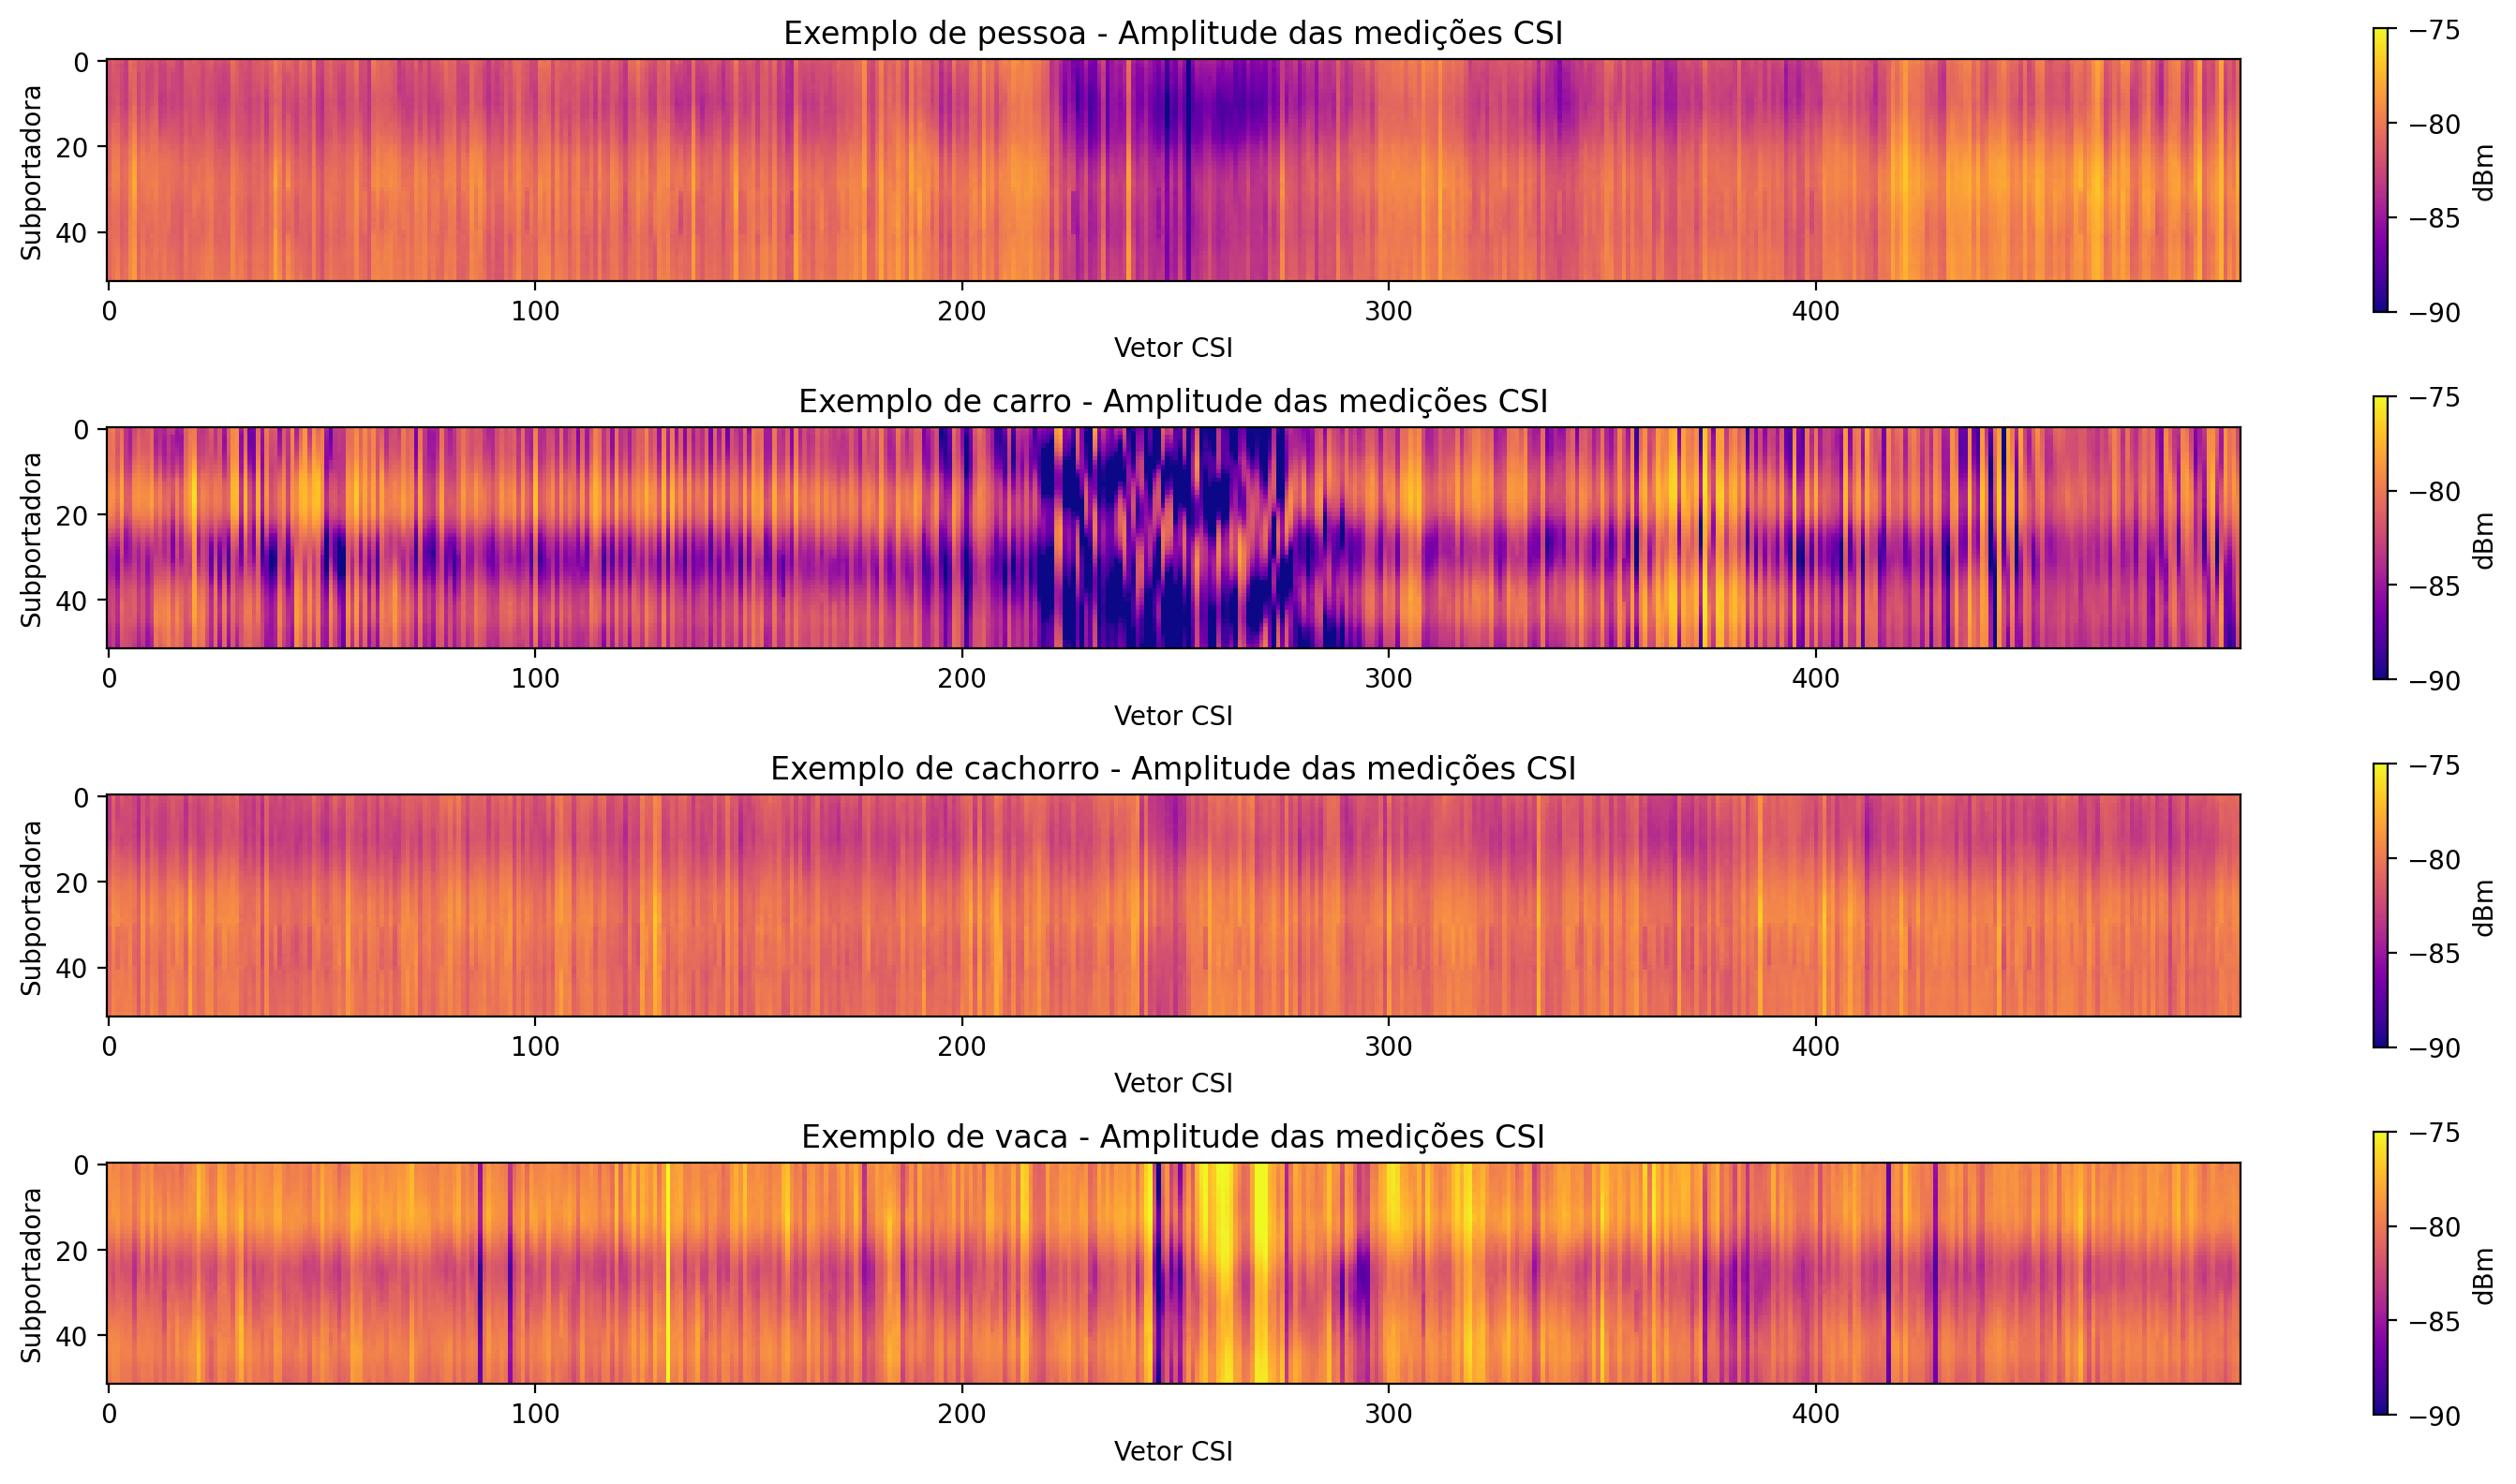

In [65]:
# Print examples
label_map_pt = {
    1: 'pessoa',
    2: 'carro',
    3: 'cachorro',
    4: 'vaca'
}

examples = pd.read_parquet('./data/TRAIN_person3_car2_dog3_cow2_noise3.parquet')

fig, ax = plt.subplots(4, 1, figsize=(15, 8), dpi=200)
for i, (label, name) in enumerate(label_map_pt.items()):
    filtered_df = examples[examples.label == label]
    example = filtered_df.iloc[10, 1:].values.reshape(500, 52).transpose(1, 0)
    im = ax[i].imshow(example, vmin=-90, vmax=-75, cmap='plasma')
    ax[i].set_title(f'Exemplo de {name} - Amplitude das medições CSI')
    ax[i].set_xlabel('Vetor CSI')
    ax[i].set_ylabel('Subportadora')
    plt.colorbar(im, ax=ax[i], label='dBm')


plt.tight_layout()
plt.show()

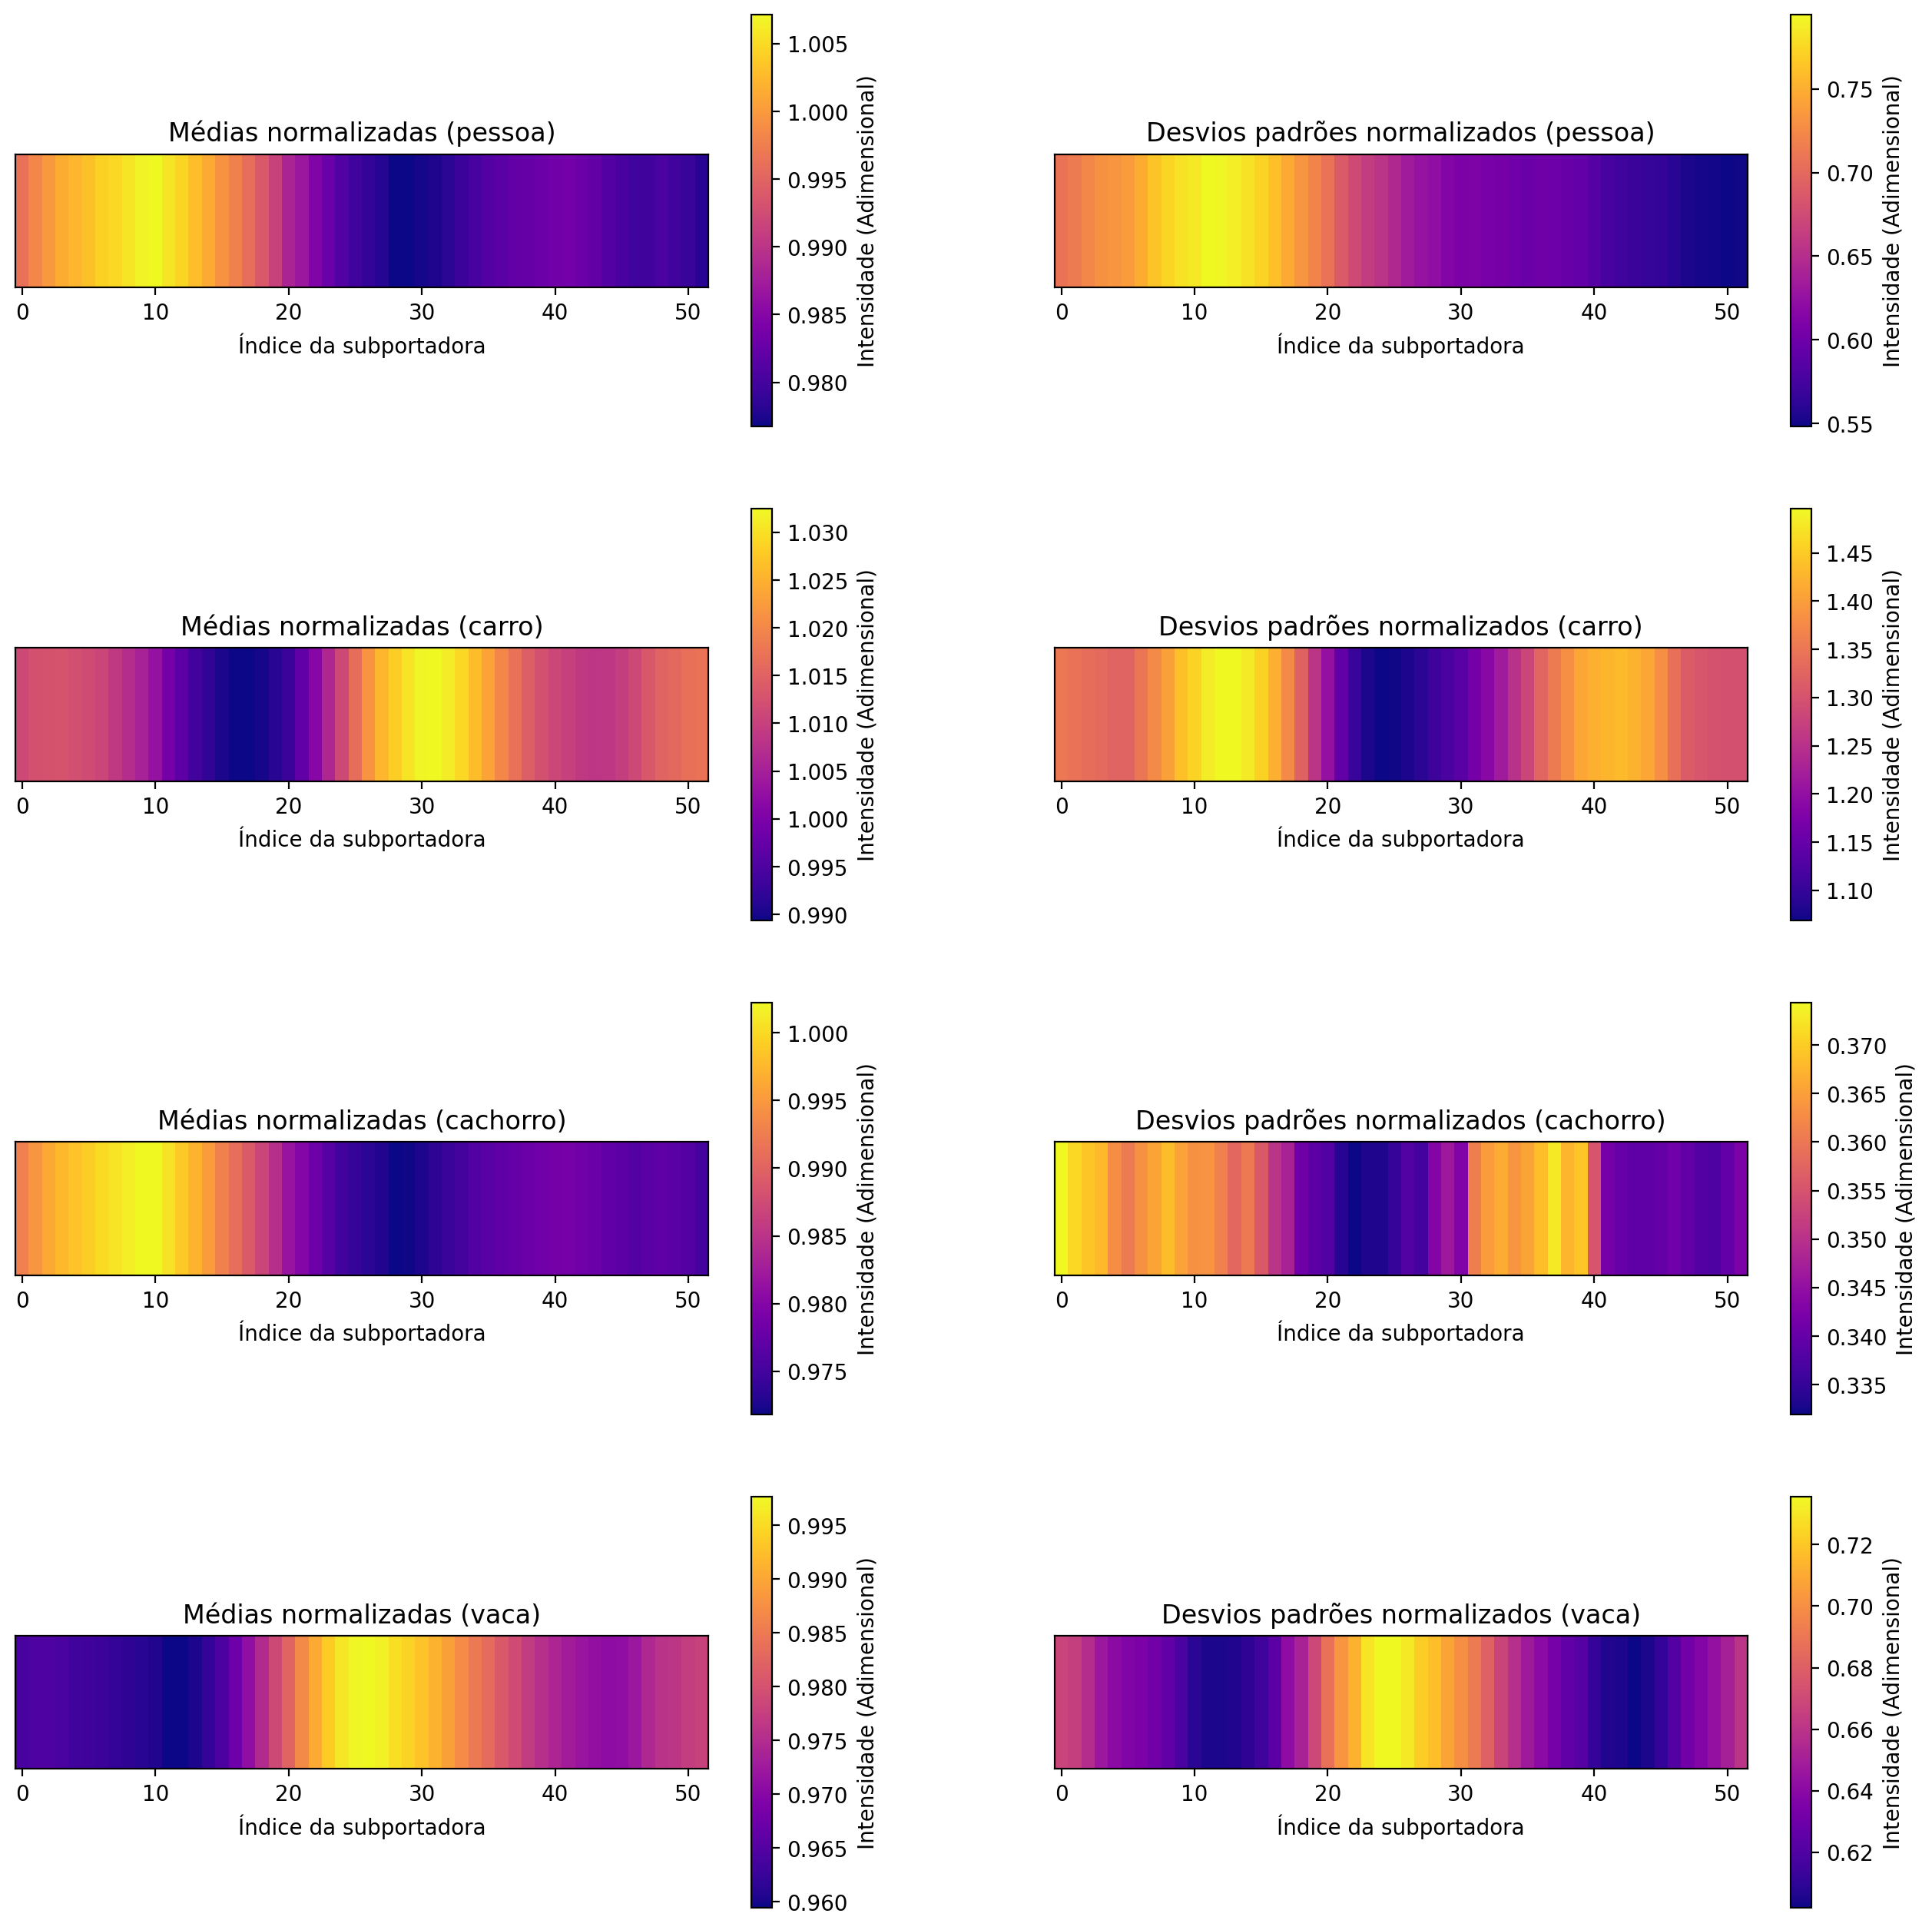

In [66]:
# Print examples



In [39]:


model = KNeighborsClassifier(n_neighbors=30)
model.fit(train_features, train['label'])
preds = model.predict(test_features)
print(accuracy_score(test['label'], preds))
print(confusion_matrix(test['label'], preds))

0.920265780730897
[[89  0  9  0]
 [ 7 56  0  0]
 [ 8  0 76  0]
 [ 0  0  0 56]]


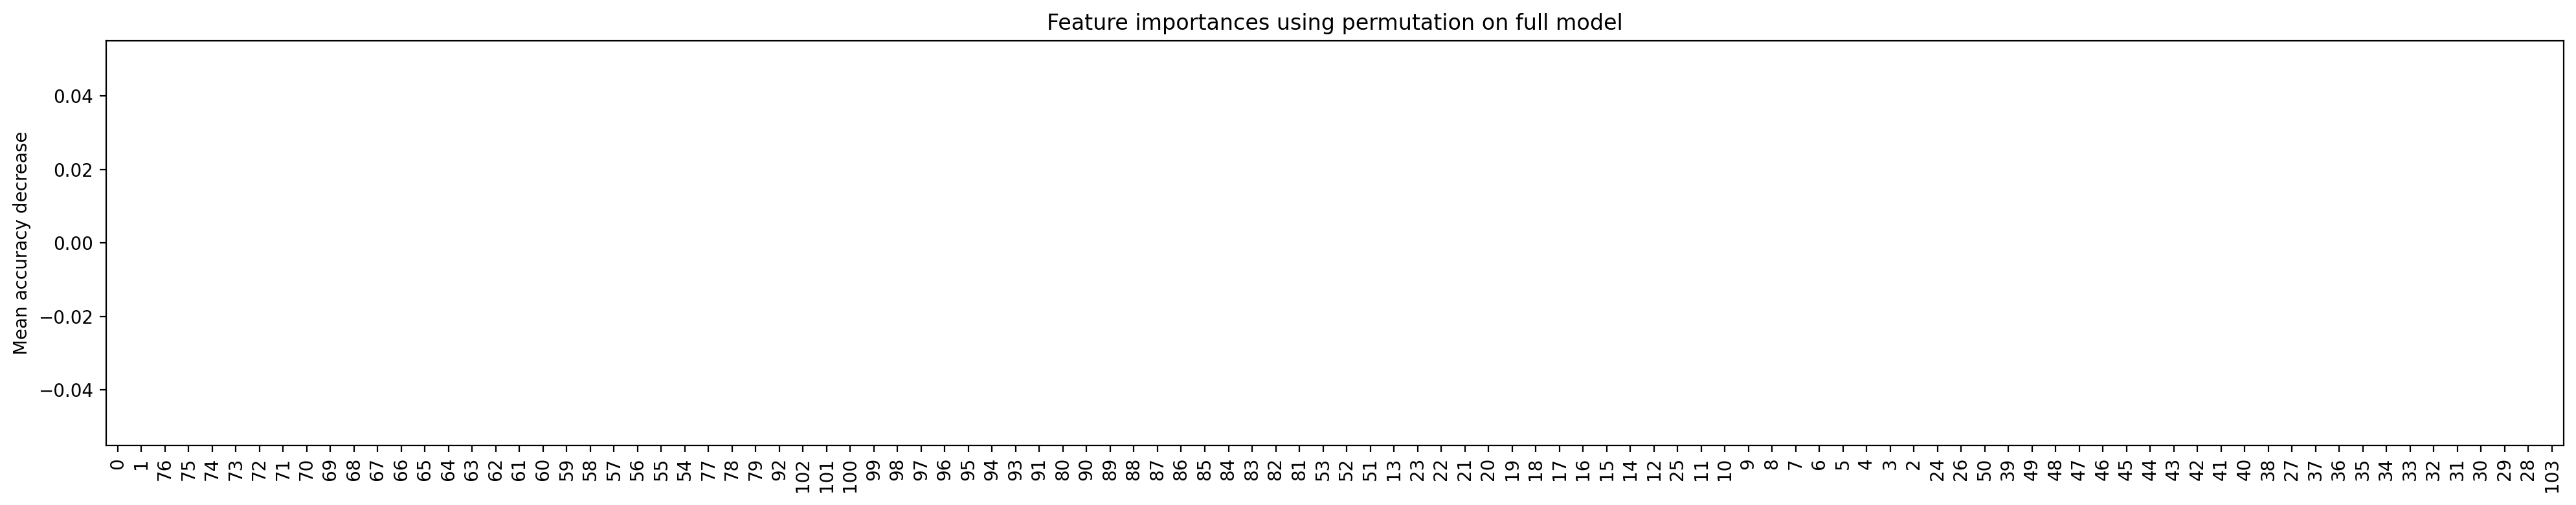

In [22]:
result = permutation_importance(model, test_features, test['label'], n_repeats=10, random_state=1)
importances = pd.DataFrame(data={'mean': result.importances_mean, 'std': result.importances_std})
importances = importances.sort_values('mean', ascending=False)

fig, ax = plt.subplots(dpi=200, figsize=(20, 4))
importances['mean'].plot.bar(yerr=importances['std'], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [73]:
important_features = importances.index[importances['mean'] > 0]
print(important_features)
print(important_features.shape)

Int64Index([0, 47, 51, 44, 48, 50], dtype='int64')
(6,)


In [23]:
important_features = np.array([40, 44, 41, 43, 42, 94, 95, 93, 46, 96, 92, 45, 39, 38, 36, 49, 97,
            15, 14, 91, 47, 37, 64, 90, 48])

NameError: name 'label_map_pt' is not defined

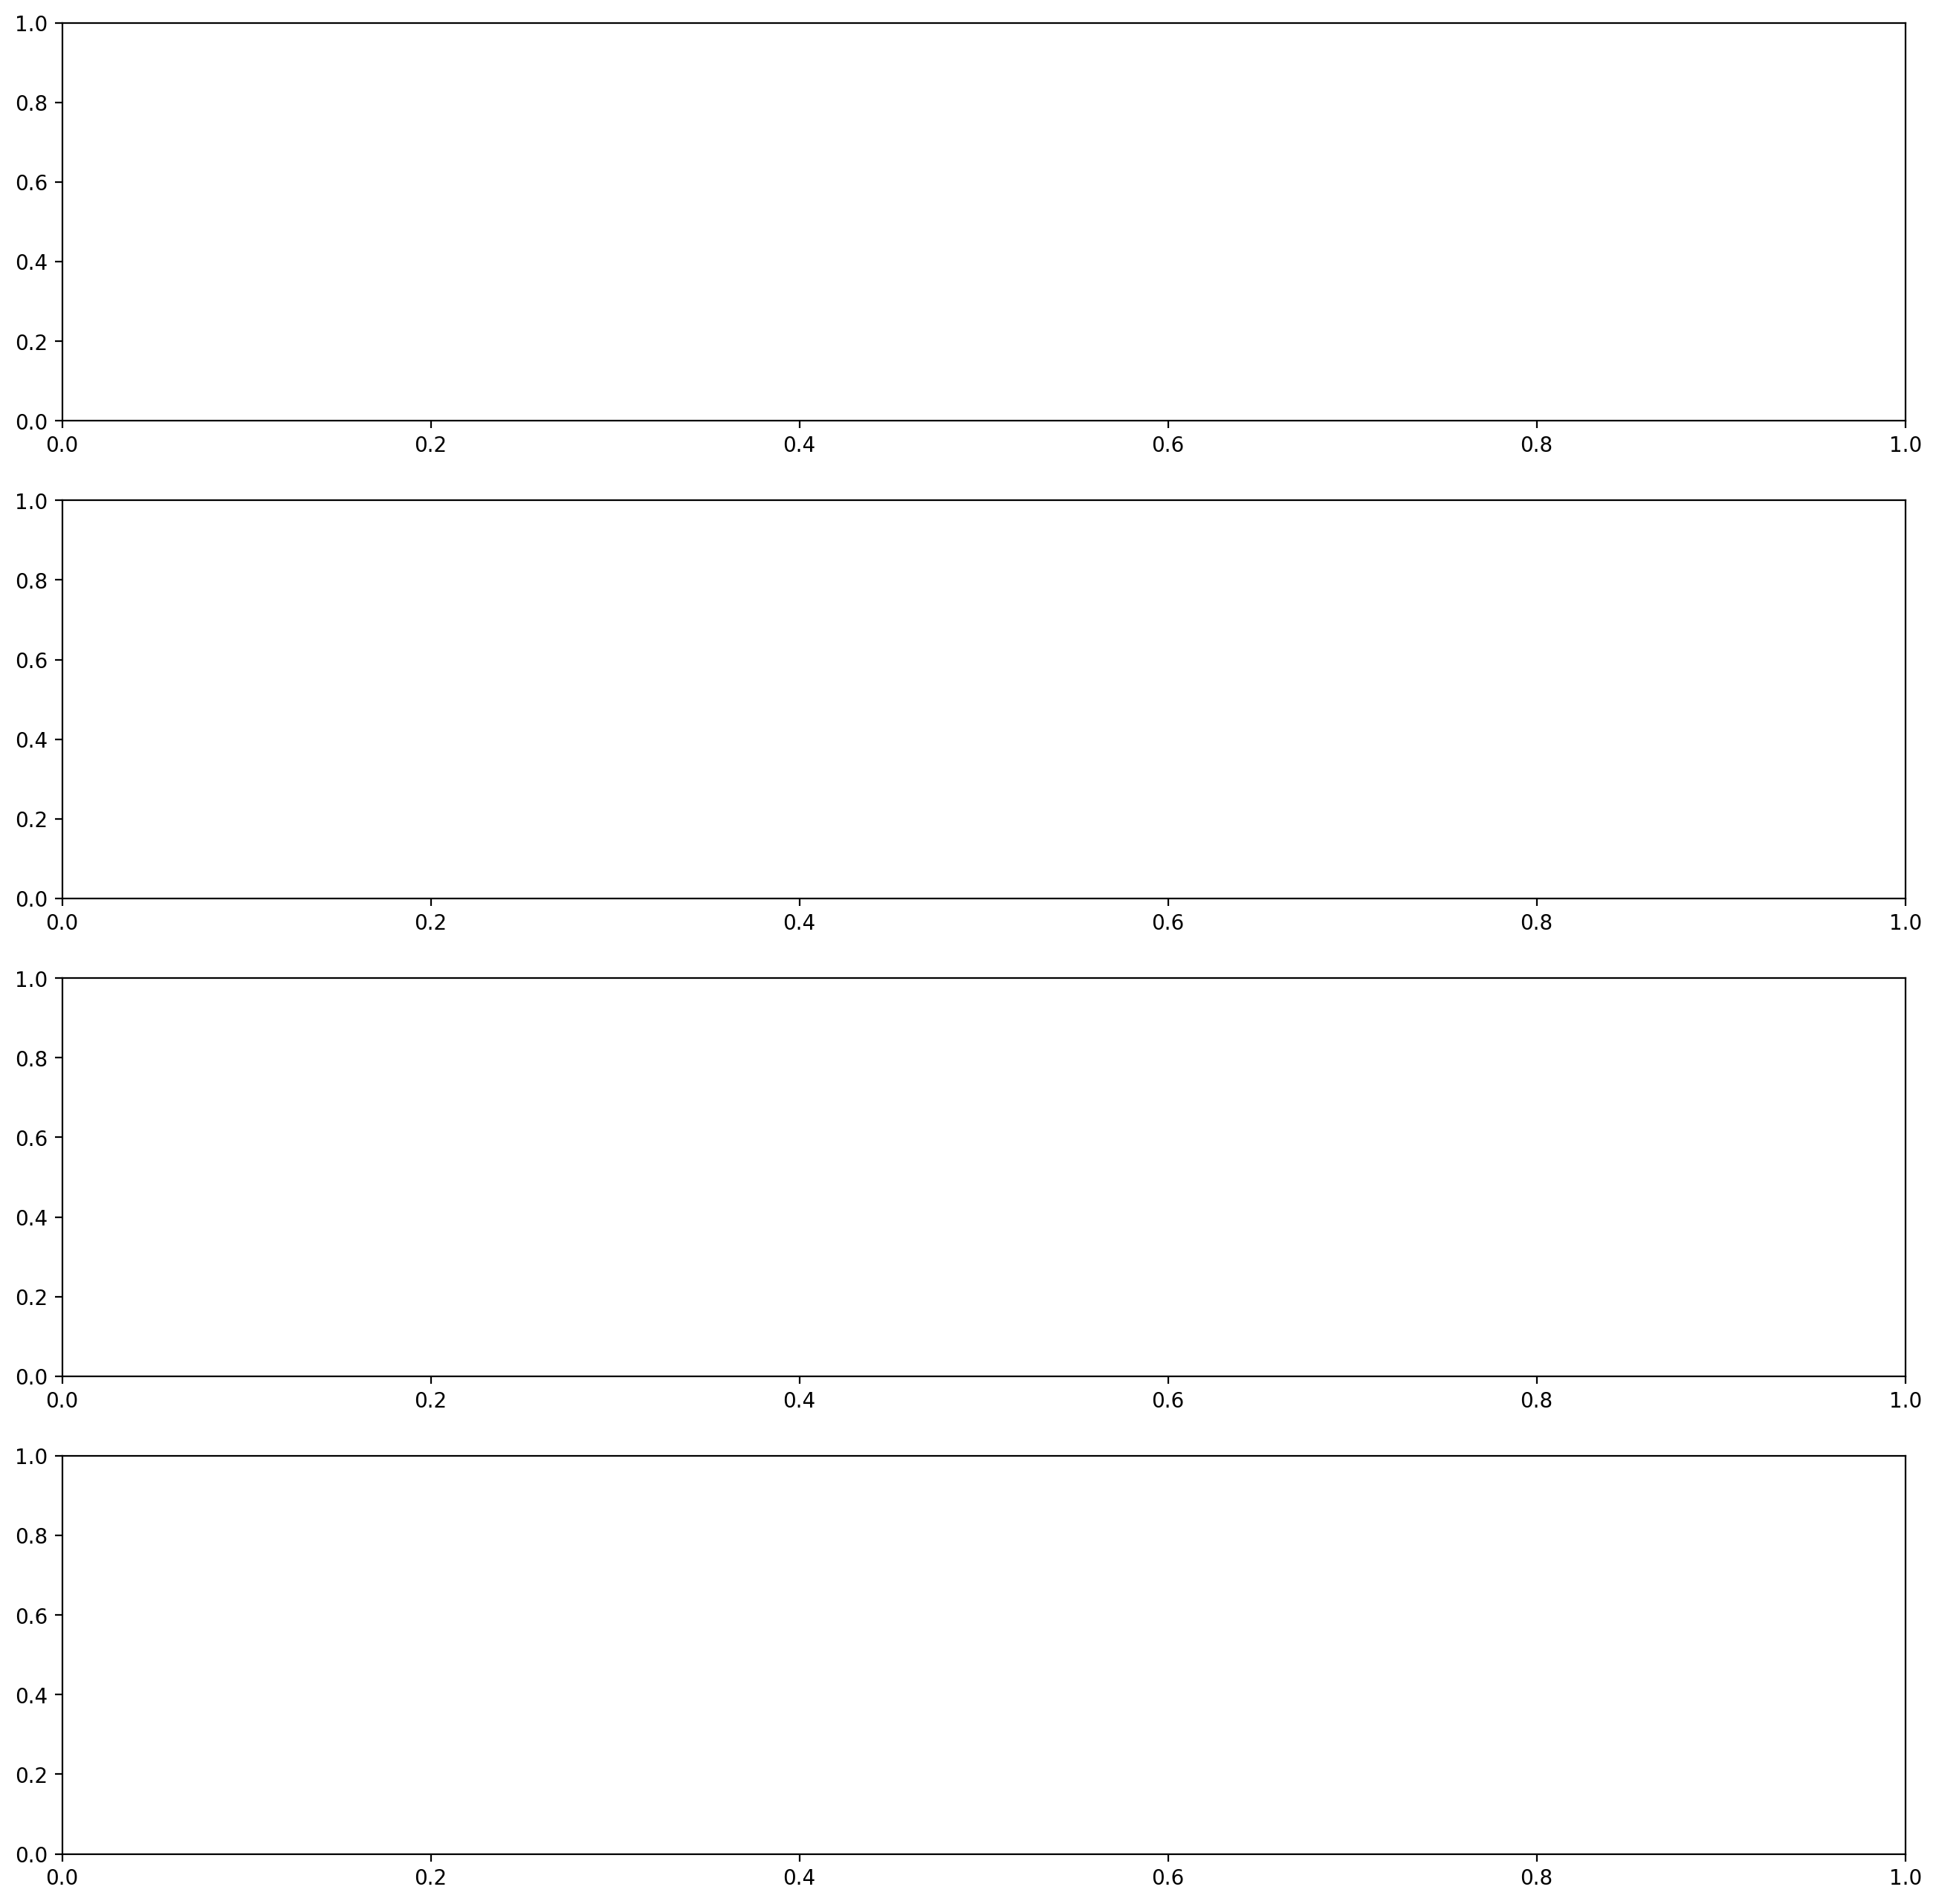

In [38]:
# Print examples
examples = pd.read_parquet('./data/TRAIN_person3_car2_dog3_cow2_noise3.parquet')

fig, ax = plt.subplots(4, 1, figsize=(16, 16), dpi=200)
for i, (label, name) in enumerate(label_map_pt.items()):
    filtered_df = examples[examples.label == label]
    example = filtered_df.iloc[1, 1:].values.reshape(500, 52).transpose(1, 0)
    example_carrier_means = example.mean(axis=1) / train_carrier_means.mean()
    example_carrier_stds = example.std(axis=1) / train_carrier_stds.mean()
    feats = np.concatenate([example_carrier_means, example_carrier_stds])
    feats = np.expand_dims(feats, axis=0)[:, important_features]
    feats = np.squeeze(feats)
    print(feats.shape)
    im = ax[i].imshow(np.expand_dims(feats, axis=0), aspect=10, cmap='plasma', vmin=0.4, vmax=1.3)
    ax[i].set_title(f'Features normalizadas ({name})')
    ax[i].set_xlabel('Índice da subportadora')
    ax[i].set_yticks([])
    plt.colorbar(im, ax=ax[i], label='Intensidade (Adimensional)')

plt.tight_layout()

plt.show()

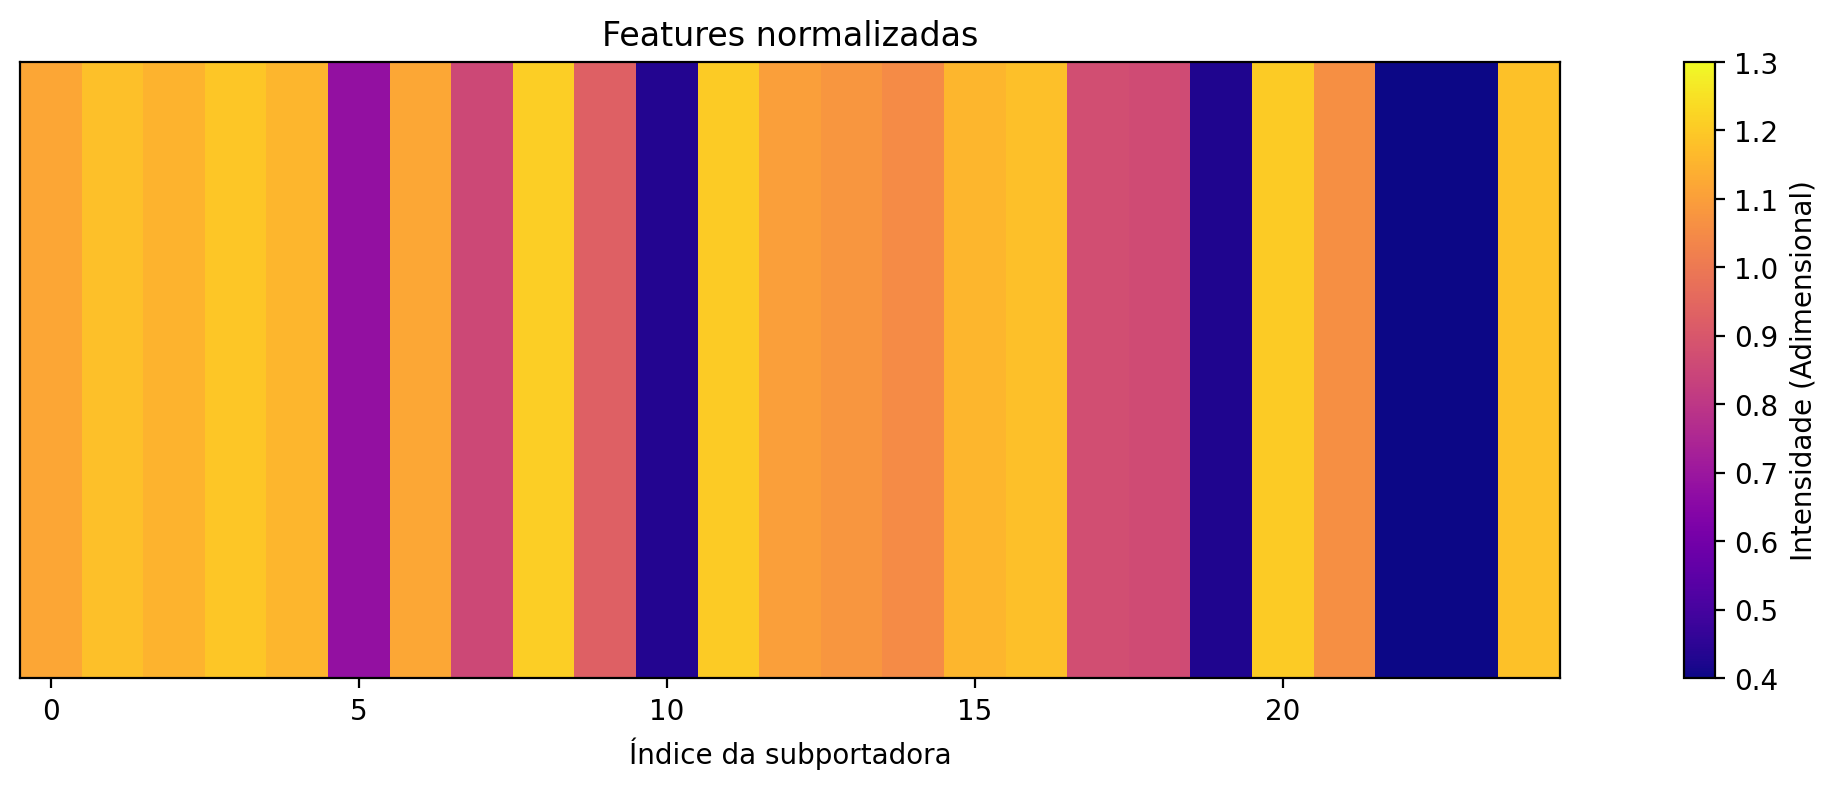

In [88]:
carro1 = np.array([1.002, 0.9844, 0.9956, 0.989, 0.9927, 0.1525, 0.1648, 0.1525, 0.9795,
                        0.1628, 0.1473, 0.9834, 1.008, 1.015, 1.018, 0.9673, 0.1665, 1.015, 1.007,
                        0.1459, 0.9766, 1.018, 0.1697, 0.1459, 0.9707])
carro2 = np.array([0.99, 0.977, 0.9834, 0.978, 0.982, 0.1637, 0.1676, 0.1554, 0.974, 0.1764, 0.1565, 0.9766, 0.994, 1., 1.006, 0.964, 0.1741, 1.019, 1.009, 0.138, 0.9717, 1.004, 0.1469, 0.1436, 0.967])

pessoa1 = np.array([1.163,1.218,1.174,1.248,1.227,1.272,1.363,0.8545,1.273,0.919,0.929,1.242,1.122,1.098,1.064,1.177,1.104,0.883,0.8745,0.5693,1.255,1.076,0.1244,0.2157,1.197])
pessoa2 = np.array([1.118, 1.178, 1.15, 1.192, 1.157, 0.68, 1.121, 0.857, 1.211, 0.9287, 0.434, 1.205, 1.102, 1.082, 1.051, 1.158, 1.177, 0.872, 0.865, 0.4255, 1.203, 1.064, 0.1262, 0.1908, 1.182])
fig, ax = plt.subplots(figsize=(16, 4), dpi=200)
im = ax.imshow(np.expand_dims(pessoa2, axis=0), aspect=10, cmap='plasma', vmin=0.4, vmax=1.3)
ax.set_title(f'Features normalizadas')
ax.set_xlabel('Índice da subportadora')
ax.set_yticks([])
plt.colorbar(im, ax=ax, label='Intensidade (Adimensional)')

In [30]:
model_input.shape

(25,)

In [24]:
train_features[:, important_features].shape

(616, 25)

In [25]:

model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_features[:, important_features], train['label'])
preds = model.predict(test_features[:, important_features])
print(accuracy_score(test['label'], preds))

1.0


In [79]:
import pickle
pickle_file = open('knn_pickle', 'wb')
pickle.dump(model, pickle_file)
pickle_file.close()

In [148]:
train_features[:, important_features].itemsize * train_features[:,important_features].size / 1000

101.752

In [53]:
confusion_matrix(test['label'], preds)

array([[79,  2, 17,  0],
       [ 0, 63,  0,  0],
       [ 7,  0, 77,  0],
       [ 0,  0,  0, 56]])